In [5]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '..'))

%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from models import model_interface, model_loader, model_constants
from data import data_loader
from data.adapters import continuous_adapter
from visualize import plot_paths

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Preliminaries -- load everything

In [30]:
DATASET, DATASET_INFO = data_loader.load_data(data_loader.DatasetName('credit_card_default'))
MODEL = model_loader.load_model(model_constants.ModelType('logistic_regression'), data_loader.DatasetName('credit_card_default'))
ADAPTER = continuous_adapter.StandardizingAdapter(
    label_column = DATASET_INFO.label_column, positive_label=DATASET_INFO.positive_label
).fit(DATASET)

cluster_df = pd.read_csv('../experiment_results/mrmc_results/mrmc_hyperparam_experiment/cluster_df.csv')
index_df = pd.read_csv('../experiment_results/mrmc_results/mrmc_hyperparam_experiment/index_df.csv')
path_df = pd.read_csv('../experiment_results/mrmc_results/mrmc_hyperparam_experiment/path_df.csv')
index_df

,batch_id,run_id,run_seed,cluster_seed,confidence_cutoff,dataset,max_iterations,model,noise_ratio,num_paths,rescale_ratio,step_size,volcano_cutoff,volcano_degree
0,43,434,4404,1834823,0.7,credit_card_default,30,logistic_regression,NaN,2,NaN,1.00,0.50,8
1,68,687,5653,1834823,0.7,credit_card_default,30,logistic_regression,NaN,3,NaN,0.50,1.00,1
2,51,511,3183,1834823,0.7,credit_card_default,30,logistic_regression,NaN,3,NaN,0.25,0.25,8
3,8,88,5323,1834823,0.7,credit_card_default,30,logistic_regression,NaN,2,NaN,0.25,1.00,1
4,41,412,1701,1834823,0.7,credit_card_default,30,logistic_regression,NaN,2,NaN,1.00,0.50,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,106,1067,5653,1834823,0.7,credit_card_default,30,logistic_regression,NaN,4,NaN,0.25,1.00,4
1916,70,709,1498,1834823,0.7,credit_card_default,30,logistic_regression,NaN,3,NaN,0.50,1.00,4
1917,159,1593,478,1834823,0.7,credit_card_default,30,logistic_regression,NaN,5,NaN,0.50,0.25,8
1918,17,177,5653,1834823,0.7,credit_card_default,30,logistic_regression,NaN,2,NaN,0.50,0.50,2


In [47]:
(30000*100*5)/(2000*60)

125.0

In [31]:
def get_path_length(path):
    path = ADAPTER.transform(path)
    if len(path) == 1:
        return np.nan
    length = 0
    for i in range(1, len(path)):
        diff = path.iloc[i] - path.iloc[i-1]
        length += np.linalg.norm(diff.to_numpy())
    return length


def analyze_paths(paths, target_certainty):
    metrics = {
        'success_ratio': 0,
    }
    path_lengths = []
    for i, path in enumerate(paths):
        if MODEL.predict_pos_proba_series(path.iloc[-1]) > target_certainty:
            metrics['success_ratio'] += 1
        path_length = get_path_length(path)
        metrics[f'path_{i}_length'] = path_length
        if not np.isnan(path_length):
            path_lengths.append(path_length)
     
    metrics['path_length'] = np.mean(path_lengths)
    metrics['success_ratio'] = metrics['success_ratio'] / len(paths)
    return metrics


def aggregate_metrics(run_metrics):
    aggregated_metrics = {}
    for metrics in run_metrics:
        for metric, metric_value in metrics.items():
            aggregated_metrics[metric] = aggregated_metrics.get(metric, []) + [metric_value]
    
    return pd.DataFrame(aggregated_metrics)


def analyze_runs(runs: pd.DataFrame, target_certainty, num_paths):
    run_metrics = []
    for run_id in runs.run_id.unique():
        paths = []
        run = runs[runs.run_id == run_id]
        for path_id in range(num_paths):
            path = run[run.path_id == path_id].sort_values(['step_id']).drop(columns=['batch_id', 'run_id', 'step_id', 'path_id'])
            paths.append(path)
        run_metrics.append(analyze_paths(paths, target_certainty))
    return aggregate_metrics(run_metrics)

# Analyze the results. This will take a while...
Expect about 5-10 minutes.

In [32]:
final_results = None

batch_ids = index_df.batch_id.unique()


for i, batch_id in enumerate(batch_ids):
    print(f"Process batch {i+1}/{len(batch_ids)}")
    batched_runs = path_df[path_df.batch_id == batch_id]
    target_certainty = index_df[index_df.batch_id == batch_id].confidence_cutoff.iloc[0]
    num_paths = index_df[index_df.batch_id == batch_id].num_paths.iloc[0]

    metrics_df = analyze_runs(batched_runs, target_certainty, num_paths)
    metrics_df['batch_id'] = batch_id
    if final_results is not None:
        final_results = pd.concat([final_results, metrics_df]).reset_index(drop=True)
    else:
        final_results = metrics_df

Process batch 1/192
Process batch 2/192
Process batch 3/192
Process batch 4/192
Process batch 5/192
Process batch 6/192
Process batch 7/192
Process batch 8/192
Process batch 9/192
Process batch 10/192
Process batch 11/192
Process batch 12/192
Process batch 13/192
Process batch 14/192
Process batch 15/192
Process batch 16/192
Process batch 17/192
Process batch 18/192
Process batch 19/192
Process batch 20/192
Process batch 21/192
Process batch 22/192
Process batch 23/192
Process batch 24/192
Process batch 25/192
Process batch 26/192
Process batch 27/192
Process batch 28/192
Process batch 29/192
Process batch 30/192
Process batch 31/192
Process batch 32/192
Process batch 33/192
Process batch 34/192
Process batch 35/192
Process batch 36/192
Process batch 37/192
Process batch 38/192
Process batch 39/192
Process batch 40/192
Process batch 41/192
Process batch 42/192
Process batch 43/192
Process batch 44/192
Process batch 45/192
Process batch 46/192
Process batch 47/192
Process batch 48/192
P

## Did we collect enough samples? Let's look at variance

It ranges from 0 (hurray!) to 0.4 (uh oh!). Why are some of the variances so high?

In [33]:
columns_to_rename = ['success_ratio', 'path_0_length', 'path_1_length', 'path_2_length', 'path_4_length', 'path_length']

std_dev_results = final_results.groupby('batch_id').std().rename(columns=dict([(name, f'{name}_std_dev') for name in columns_to_rename])).sort_values('success_ratio_std_dev')
std_dev_results

,success_ratio_std_dev,path_0_length_std_dev,path_1_length_std_dev,path_length_std_dev,path_2_length_std_dev,path_3_length,path_4_length_std_dev
batch_id,,,,,,,
95,0.000000,2.798809,2.726414,4.110961,7.087548,NaN,NaN
92,0.000000,3.169297,2.330951,3.777124,6.074537,NaN,NaN
93,0.000000,3.169297,2.485514,3.883488,6.275172,NaN,NaN
94,0.000000,3.128720,2.558211,4.002468,6.599663,NaN,NaN
190,0.000000,2.485514,2.867442,3.465961,2.859681,6.599663,2.884826
...,...,...,...,...,...,...,...
52,0.399073,2.630088,2.242890,2.583244,3.111471,NaN,NaN
57,0.399073,2.541462,2.229225,2.546860,3.114036,NaN,NaN
53,0.399073,2.584140,2.229225,2.558332,3.114036,NaN,NaN


### We can plot the standard deviation

It's hard to interpret this plot. Maybe there are some runs with low standard
deviation and some with high standard deviation?

<AxesSubplot: xlabel='n_runs', ylabel='success_ratio'>

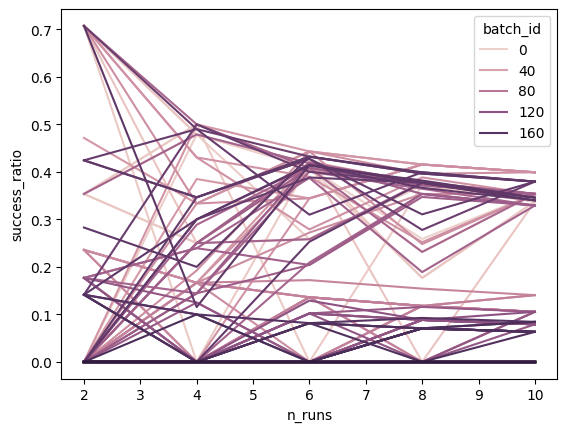

In [34]:
run_subset_dfs = []
for n_runs in [2, 4, 6, 8, 10]:
    df = final_results.groupby('batch_id').sample(n=n_runs, replace=False).groupby('batch_id').std().sort_values('success_ratio')
    df['batch_id'] = df.index
    df['n_runs'] = n_runs
    run_subset_dfs.append(df)

std_dev_vs_n_runs_df = pd.concat(run_subset_dfs).reset_index(drop=True)
sns.lineplot(std_dev_vs_n_runs_df, x='n_runs', y='success_ratio', hue='batch_id')

### Most runs have low standard deviation, but some have high standard deviation

In [35]:
low_standard_dev_results = std_dev_vs_n_runs_df[(std_dev_vs_n_runs_df.n_runs == 10) & (std_dev_vs_n_runs_df.success_ratio < 0.2)]
high_standard_dev_results = std_dev_vs_n_runs_df[(std_dev_vs_n_runs_df.n_runs == 10) & (std_dev_vs_n_runs_df.success_ratio >= 0.2)]

print(f"There are {len(low_standard_dev_results)} batches with low standard deviation")
print(f"There are {len(high_standard_dev_results)} batches with high standard deviation")

There are 144 batches with low standard deviation
There are 48 batches with high standard deviation


### Only batches with step_size = 0.25 have high standard deviation

Why?

In [36]:
high_dev_ids = high_standard_dev_results.batch_id.unique()
low_dev_ids = low_standard_dev_results.batch_id.unique()

low_counts = index_df[index_df.batch_id.isin(low_dev_ids)].drop_duplicates('batch_id').groupby('step_size').count()[['batch_id']]
low_counts['std_dev'] = '< 0.2'

high_counts = index_df[index_df.batch_id.isin(high_dev_ids)].drop_duplicates('batch_id').groupby('step_size').count()[['batch_id']]
high_counts['std_dev'] = '>= 0.2'

pd.concat([low_counts, high_counts]).sort_values('step_size')

,batch_id,std_dev
step_size,,
0.25,48,>= 0.2
0.50,48,< 0.2
0.75,48,< 0.2
1.00,48,< 0.2


## Get more data on step_size=0.25

This is the step size with high variance. Does it ever stabilize?

In [21]:
cluster_df_2 = pd.read_csv('../experiment_results/mrmc_results/mrmc_hyperparam_experiment_high_var/cluster_df.csv')
index_df_2 = pd.read_csv('../experiment_results/mrmc_results/mrmc_hyperparam_experiment_high_var/index_df.csv')
path_df_2 = pd.read_csv('../experiment_results/mrmc_results/mrmc_hyperparam_experiment_high_var/path_df.csv')
index_df_2

,batch_id,run_id,run_seed,cluster_seed,confidence_cutoff,dataset,max_iterations,model,noise_ratio,num_paths,rescale_ratio,step_size,volcano_cutoff,volcano_degree
0,3,107,1573,1834823,0.7,credit_card_default,30,logistic_regression,NaN,2,NaN,0.25,0.25,8
1,24,724,4404,1834823,0.7,credit_card_default,30,logistic_regression,NaN,4,NaN,0.25,0.25,1
2,44,1328,5323,1834823,0.7,credit_card_default,30,logistic_regression,NaN,5,NaN,0.25,1.00,1
3,34,1040,9560,1834823,0.7,credit_card_default,30,logistic_regression,NaN,4,NaN,0.25,1.00,4
4,5,170,9560,1834823,0.7,credit_card_default,30,logistic_regression,NaN,2,NaN,0.25,0.50,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,1,41,7699,1834823,0.7,credit_card_default,30,logistic_regression,NaN,2,NaN,0.25,0.25,2
1436,0,6,4340,1834823,0.7,credit_card_default,30,logistic_regression,NaN,2,NaN,0.25,0.25,1
1437,44,1331,7699,1834823,0.7,credit_card_default,30,logistic_regression,NaN,5,NaN,0.25,1.00,1
1438,29,882,4470,1834823,0.7,credit_card_default,30,logistic_regression,NaN,4,NaN,0.25,0.50,2


In [25]:
final_results = None

batch_ids = index_df_2.batch_id.unique()

for i, batch_id in enumerate(batch_ids):
    print(f"Process batch {i+1}/{len(batch_ids)}")
    batched_runs = path_df_2[path_df_2.batch_id == batch_id]
    target_certainty = index_df_2[index_df_2.batch_id == batch_id].confidence_cutoff.iloc[0]
    num_paths = index_df_2[index_df_2.batch_id == batch_id].num_paths.iloc[0]

    metrics_df = analyze_runs(batched_runs, target_certainty, num_paths)
    metrics_df['batch_id'] = batch_id
    if final_results is not None:
        final_results = pd.concat([final_results, metrics_df]).reset_index(drop=True)
    else:
        final_results = metrics_df

Process batch 1/48
Process batch 2/48
Process batch 3/48
Process batch 4/48
Process batch 5/48
Process batch 6/48
Process batch 7/48
Process batch 8/48
Process batch 9/48
Process batch 10/48
Process batch 11/48
Process batch 12/48
Process batch 13/48
Process batch 14/48
Process batch 15/48
Process batch 16/48
Process batch 17/48
Process batch 18/48
Process batch 19/48
Process batch 20/48
Process batch 21/48
Process batch 22/48
Process batch 23/48
Process batch 24/48
Process batch 25/48
Process batch 26/48
Process batch 27/48
Process batch 28/48
Process batch 29/48
Process batch 30/48
Process batch 31/48
Process batch 32/48
Process batch 33/48
Process batch 34/48
Process batch 35/48
Process batch 36/48
Process batch 37/48
Process batch 38/48
Process batch 39/48
Process batch 40/48
Process batch 41/48
Process batch 42/48
Process batch 43/48
Process batch 44/48
Process batch 45/48
Process batch 46/48
Process batch 47/48
Process batch 48/48


In [26]:
std_dev_results = final_results.groupby('batch_id').std().rename(columns={'success_ratio': 'std_dev_of_success_ratio'}).sort_values('std_dev_of_success_ratio')
std_dev_results

,std_dev_of_success_ratio
batch_id,
35,0.304303
31,0.304303
27,0.304303
34,0.311305
26,0.311305
30,0.311305
33,0.319505
29,0.319505
25,0.319505


<AxesSubplot: xlabel='n_runs', ylabel='std_dev_of_success_ratio'>

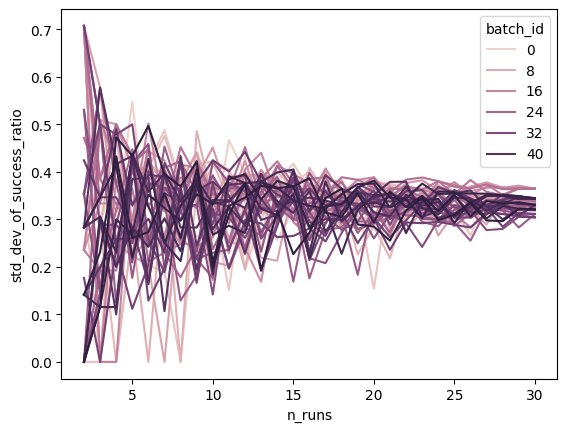

In [27]:
run_subset_dfs = []
for n_runs in range(2, 31):
    df = final_results.groupby('batch_id').sample(n=n_runs, replace=False).groupby('batch_id').std().sort_values('success_ratio')
    df['batch_id'] = df.index
    df['n_runs'] = n_runs
    run_subset_dfs.append(df)

std_dev_vs_n_runs_df = pd.concat(run_subset_dfs).reset_index(drop=True).rename(columns={'success_ratio': 'std_dev_of_success_ratio'})
sns.lineplot(std_dev_vs_n_runs_df, x='n_runs', y='std_dev_of_success_ratio', hue='batch_id')

In [28]:
mean_results = final_results.groupby('batch_id').mean().sort_values('success_ratio').rename(columns={'success_ratio': 'avg_success_ratio'})

results = pd.merge(mean_results, index_df_2.drop_duplicates('batch_id')[['batch_id', 'num_paths', 'step_size', 'volcano_cutoff', 'volcano_degree']], on='batch_id')
results

,batch_id,avg_success_ratio,num_paths,step_size,volcano_cutoff,volcano_degree
0,44,0.633333,5,0.25,1.00,1
1,40,0.633333,5,0.25,0.50,1
2,21,0.633333,3,0.25,1.00,2
3,36,0.633333,5,0.25,0.25,1
4,20,0.633333,3,0.25,1.00,1
5,12,0.633333,3,0.25,0.25,1
6,13,0.633333,3,0.25,0.25,2
7,17,0.633333,3,0.25,0.50,2
8,16,0.633333,3,0.25,0.50,1
9,45,0.646667,5,0.25,1.00,2


### Why do the paths sometimes fail?

Visualize some of the paths. It turns out the step size is too small!

In [29]:
def random_run(batch: pd.DataFrame, seed: int):
    run_id = np.random.default_rng(seed).choice(batch.run_id.unique(), 1)[0]
    run = batch[batch.run_id == run_id]
    paths = []
    path_ids = sorted(run.path_id.unique())
    for path_id in path_ids:
        path = run[run.path_id == path_id].sort_values('step_id').drop(columns=['step_id', 'path_id', 'run_id', 'batch_id'])
        paths.append(path)
    return paths

paths = random_run(path_df_2[path_df_2.batch_id == 21], 129348)

for i, path in enumerate(paths):
    proba = MODEL.predict_pos_proba_series(path.iloc[-1])
    cutoff = index_df_2.confidence_cutoff.unique()[0]
    if proba > cutoff:
        print(f"Path {i} succeeds with probability {proba} > {cutoff}")
    else:
        print(f"Path {i} fails with probability {proba} <= {cutoff}")

Path 0 fails with probability 0.5610064107110914 <= 0.7
Path 1 fails with probability 0.658851722282183 <= 0.7
Path 2 fails with probability 0.27386006278441766 <= 0.7


/home/jakeval/umass/research/.venv/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


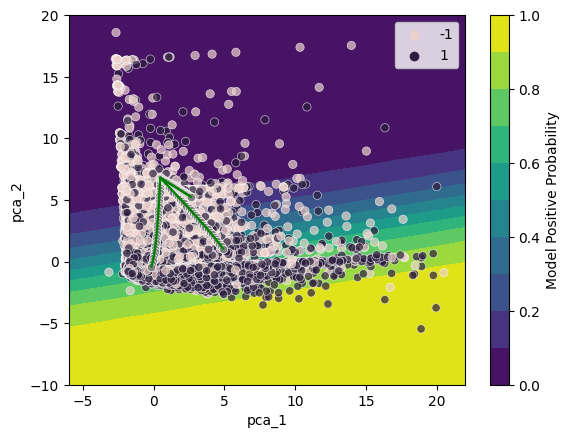

In [34]:
plot_paths.plot_stuff(
    model=MODEL,
    dataset=DATASET,
    dataset_info=DATASET_INFO,
    paths=paths,
    confidence_cutoff=None,
    xlim=(-6, 22),
    ylim=(-10, 20)
)

# Let's look at the average over low standard deviation samples

We see that the results are fairly stable -- the average success ratio is high.

In [37]:
result_subset = final_results[final_results.batch_id.isin(low_dev_ids)]

mean_results = result_subset.groupby('batch_id').mean().sort_values('success_ratio')
mean_results

,success_ratio,path_0_length,path_1_length,path_length,path_2_length,path_3_length,path_4_length
batch_id,,,,,,,
71,0.933333,5.3,3.70,5.3000,6.9,NaN,NaN
63,0.933333,5.3,3.70,5.3000,6.9,NaN,NaN
67,0.933333,5.3,3.70,5.3000,6.9,NaN,NaN
115,0.950000,3.7,5.35,4.9375,6.9,3.8,NaN
111,0.950000,3.7,5.35,4.9375,6.9,3.8,NaN
...,...,...,...,...,...,...,...
45,1.000000,4.2,5.70,4.9500,NaN,NaN,NaN
44,1.000000,3.9,5.60,4.7500,NaN,NaN,NaN
43,1.000000,3.9,5.60,4.7500,NaN,NaN,NaN


In [40]:
mean_results = pd.merge(mean_results, index_df[['batch_id', 'num_paths', 'step_size', 'volcano_cutoff', 'volcano_degree']], on='batch_id')
mean_results

,batch_id,success_ratio,path_0_length,path_1_length,path_length,path_2_length,path_3_length,path_4_length,num_paths,step_size,volcano_cutoff,volcano_degree
0,71,0.933333,5.3,3.7,5.30,6.9,NaN,NaN,3,0.5,1.0,8
1,71,0.933333,5.3,3.7,5.30,6.9,NaN,NaN,3,0.5,1.0,8
2,71,0.933333,5.3,3.7,5.30,6.9,NaN,NaN,3,0.5,1.0,8
3,71,0.933333,5.3,3.7,5.30,6.9,NaN,NaN,3,0.5,1.0,8
4,71,0.933333,5.3,3.7,5.30,6.9,NaN,NaN,3,0.5,1.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...
1435,191,1.000000,3.9,5.5,5.36,3.8,7.7,5.9,5,1.0,1.0,8
1436,191,1.000000,3.9,5.5,5.36,3.8,7.7,5.9,5,1.0,1.0,8
1437,191,1.000000,3.9,5.5,5.36,3.8,7.7,5.9,5,1.0,1.0,8
1438,191,1.000000,3.9,5.5,5.36,3.8,7.7,5.9,5,1.0,1.0,8


In [43]:
mean_results.sort_values('path_length')

,batch_id,success_ratio,path_0_length,path_1_length,path_length,path_2_length,path_3_length,path_4_length,num_paths,step_size,volcano_cutoff,volcano_degree
1049,19,1.0,3.65,5.35,4.5,NaN,NaN,NaN,2,0.5,0.50,8
1087,15,1.0,3.65,5.35,4.5,NaN,NaN,NaN,2,0.5,0.25,8
1086,15,1.0,3.65,5.35,4.5,NaN,NaN,NaN,2,0.5,0.25,8
1085,15,1.0,3.65,5.35,4.5,NaN,NaN,NaN,2,0.5,0.25,8
1084,15,1.0,3.65,5.35,4.5,NaN,NaN,NaN,2,0.5,0.25,8
...,...,...,...,...,...,...,...,...,...,...,...,...
835,95,1.0,5.50,3.90,5.7,7.7,NaN,NaN,3,1.0,1.00,8
836,95,1.0,5.50,3.90,5.7,7.7,NaN,NaN,3,1.0,1.00,8
837,95,1.0,5.50,3.90,5.7,7.7,NaN,NaN,3,1.0,1.00,8
831,95,1.0,5.50,3.90,5.7,7.7,NaN,NaN,3,1.0,1.00,8


## Total Distribution

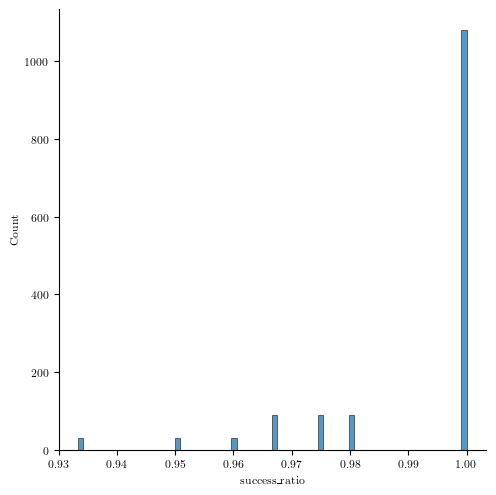

In [175]:
sns.displot(results, x='success_ratio')

## Step Size

Some of the paths with step size 0.5 don't succeed. Why not?

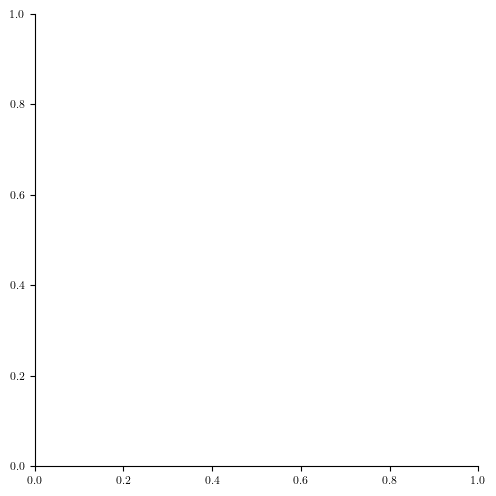

In [239]:
sns.displot(results[results.step_size == 0.75], x='success_ratio')

In [83]:
results

,batch_id,success_ratio,num_paths,step_size,volcano_cutoff,volcano_degree
0,57,0.7,3,0.25,1.0,2
1,57,0.7,3,0.25,1.0,2
2,57,0.7,3,0.25,1.0,2
3,57,0.7,3,0.25,1.0,2
4,57,0.7,3,0.25,1.0,2
...,...,...,...,...,...,...
1915,191,1.0,5,1.00,1.0,8
1916,191,1.0,5,1.00,1.0,8
1917,191,1.0,5,1.00,1.0,8
1918,191,1.0,5,1.00,1.0,8
